In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import optuna
import csv
import pandas as pd
import random

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1) Dataset

### 📌 **Loading and Preparing CIFAR-10 Dataset**

- `unpickle(file)`: Helper function to load CIFAR-10 data files saved in pickle format.
- `data_dir`: Path to the extracted CIFAR-10 dataset directory.
- `label_names`: List of class names (e.g., *airplane*, *cat*, *dog*, etc.) loaded from `batches.meta`.

#### **Training Data:**
- CIFAR-10 training set is split into 5 batches (each with 10,000 images).
- We:
  - Loop through each batch (`data_batch_1` to `data_batch_5`).
  - Extract the image data (`b'data'`) and labels (`b'labels'`).
  - Append all data and labels to lists (`train_data_list`, `train_labels_list`).
- After loading:
  - Concatenate all training batches into a single array of shape `[50000, 3072]`.
  - Reshape to `[50000, 3, 32, 32]`, where each image has 3 color channels and 32x32 pixels.

#### **Test Data:**
- Test data is loaded from `test_batch` in the same way.
- Reshaped to `[10000, 3, 32, 32]`.

#### **Converting to PyTorch Tensors and DataLoader:**
- Use `torch.tensor()` to convert image and label arrays to PyTorch tensors.
- Wrap tensors in `TensorDataset`, so each sample is a `(image, label)` pair.
- Use `DataLoader` to create:
  - `train_loader`: Batches of 64 training samples, shuffled.
  - `test_loader`: Batches of 64 test samples, no shuffling.

#### **Inspecting a Sample Batch:**
- Use `iter(train_loader)` to create an iterator.
- Use `next(data_iter)` to get one batch of `(images, labels)`.
- Print their shapes:
  - `images.shape`: Should be `[64, 3, 32, 32]`
  - `labels.shape`: Should be `[64]` (one label per image)


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Set the path to the directory where you downloaded the files
data_dir = './cifar-10-batches-py/'

meta = unpickle(f"{data_dir}/batches.meta")
label_names = [label.decode('utf-8') for label in meta[b'label_names']]

# Load and combine the 5 training batches
train_data_list = []
train_labels_list = []
for i in range(1, 6):
    batch = unpickle(f"{data_dir}/data_batch_{i}")
    train_data_list.append(batch[b'data']) # each row contains 1 image, columns stand for pixel intensity values for each 3 channels
    train_labels_list += batch[b'labels']  # contains values from 0-9, indicating class

Shape before reshaping (Image 0): (3072,)
Shape after reshaping (frog): (3, 32, 32)
Shape before reshaping (Image 1): (3072,)
Shape after reshaping (truck): (3, 32, 32)
Shape before reshaping (Image 2): (3072,)
Shape after reshaping (truck): (3, 32, 32)
Shape before reshaping (Image 3): (3072,)
Shape after reshaping (deer): (3, 32, 32)
Shape before reshaping (Image 4): (3072,)
Shape after reshaping (automobile): (3, 32, 32)
Shape before reshaping (Image 5): (3072,)
Shape after reshaping (automobile): (3, 32, 32)


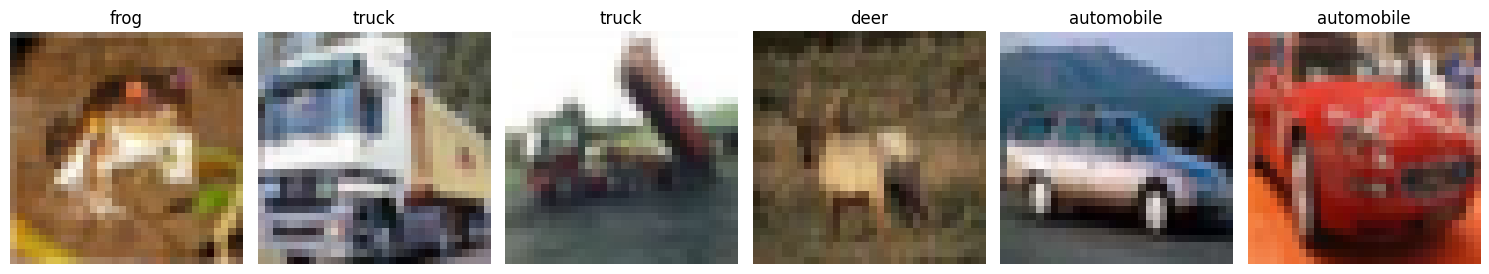

In [5]:
# DEMONSTRATION
fig, axs = plt.subplots(1, 6, figsize=(15, 3))

# Loop over 6 images
for i in range(6):
    # Extract the flattened image (each image has 3072 values)
    flat_image = train_data_list[0][i]  # Using the first batch and the i-th image
    print(f"Shape before reshaping (Image {i}):", flat_image.shape)  # (3072,)

    # Reshape the flat image into (3, 32, 32)
    image_reshaped = flat_image.reshape(3, 32, 32)
    print(f"Shape after reshaping ({label_names[train_labels_list[i]]}):", image_reshaped.shape)  # (3, 32, 32)

    # Transpose to shape (32, 32, 3) for visualization
    image_for_plot = np.transpose(image_reshaped, (1, 2, 0))

    # Display the image in the subplot
    axs[i].imshow(image_for_plot)
    axs[i].set_title(f"{label_names[train_labels_list[i]]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# previously [50000, 3072] array reshaped into [50000, 3, 32, 32]

train_data = np.concatenate(train_data_list, axis=0) # Concatenating 5 batches
train_data = train_data.reshape(-1, 3, 32, 32)
train_labels = np.array(train_labels_list)

test_batch = unpickle(f"{data_dir}/test_batch")
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])
test_data = test_data.reshape(-1, 3, 32, 32)

In [7]:
# Convert the data to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset objects for training and testing data
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)

# Create DataLoaders to generate batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# Example usage: iterate over one batch from the training DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

Images batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


In [ ]:
def accuracy_fn(y_true, y_pred):
    # Calculate the number of correct predictions by comparing y_true and y_pred
    correct = torch.eq(y_true, y_pred).sum().item()

    # Calculate accuracy as the ratio of correct predictions to total predictions
    acc = (correct / len(y_pred)) * 100

    return acc

# 2) Architecture

### How Our Implementation Matches the Paper


---

#### 1. Intermediate Block

**Requirements:**
- Each intermediate block $ B_k $ contains **L independent convolutional layers**.
- All convolution layers receive the **same input image $ x $**.
- Each convolution  $ C_l(x) $  produces an output, which are combined via a **weighted sum**:
  \[
  $ x' = a_1 C_1(x) + a_2 C_2(x) + \dots + a_L C_L(x) $
  \]
- The weight vector  $ \mathbf{a} $  is computed by applying **global average pooling** on $ x $, followed by a **fully connected layer** and softmax.

**How our `IntermediateBlock` implements this:**
- `num_parallel` convolution layers created via `nn.ModuleList` — ✅
- All operate on the same input $ x $ — ✅
- We compute a weight vector `a` using:
  - `nn.AdaptiveAvgPool2d` for global pooling
  - `nn.Linear` for fully connected mapping
  - `F.softmax` for normalization — ✅
- Final output is a **weighted sum** of the parallel branches using `a` — ✅

---

#### 2. Output Block 

**Requirements:**
- Receives output from the last intermediate block.
- Applies **global average pooling** across channels.
- The pooled vector is fed into one or more **fully connected layers** to produce the **logits vector $ o $**.

**How our `CIFAR10Net` class implements this:**
- After intermediate blocks, we apply:
  - `nn.AdaptiveAvgPool2d((1, 1))` — ✅
  - Flattening to get the vector form — ✅
  - Final linear layer `self.fc` to produce logits — ✅

---

#### 3. Overall Architecture 

**Requirements:**
- The network consists of:
  \[
  $ B_1 \rightarrow B_2 \rightarrow \dots \rightarrow B_K \rightarrow O $
  \]

**How our `CIFAR10Net` models this:**
- A stack of `num_blocks` intermediate blocks using `nn.Sequential` — ✅
- Followed by the output block (global pool + FC) — ✅


In [ ]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_parallel, kernel_size, padding, activation=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList([])
        for _ in range(num_parallel):
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                activation
            ))
        # Global average pooling and a linear layer to compute weights
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_parallel)


        self.num_parallel = num_parallel

    def forward(self, x):
        # Compute outputs for each parallel convolution
        conv_outputs = [conv(x) for conv in self.convs]  # Each shape: (N, out_channels, H, W)

        # Compute weights for each convolutional branch
        pooled = self.global_pool(x)           
        pooled = pooled.view(pooled.size(0), -1)   
        a = self.fc(pooled)                       
        a = F.softmax(a, dim=1)                   

        # Weighted sum of the convolution outputs
        out = 0
        for l in range(self.num_parallel):
            out += conv_outputs[l] * a[:, l].view(-1, 1, 1, 1)

 
        return out  # (N, out_channels, H, W)

# Define the IntermediateBlock class
class CIFAR10Net(nn.Module):
    def __init__(self,
                 in_channels,
                 num_classes,
                 out_channels,
                 num_blocks,
                 num_parallel,
                 kernel_size,
                 padding
                 ):
        """
        Args:
            in_channels  : Number of channels in input images (3 for RGB).
            num_classes  : Number of output classes (10 for CIFAR-10).
            out_channels : Number of output channels for each IntermediateBlock.
            num_blocks   : How many IntermediateBlocks to stack.
            num_parallel : L, how many parallel convs in each block.
        """
        super().__init__()

        # Build a sequence of intermediate blocks
        blocks = []
        current_channels = in_channels
        for _ in range(num_blocks):
            blocks.append(IntermediateBlock(current_channels, out_channels, num_parallel, kernel_size, padding))
            current_channels = out_channels
        self.blocks = nn.Sequential(*blocks)

        # global average pool + linear layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        # Pass through each intermediate block
        x = self.blocks(x)

        # Global average pool -> (N, out_channels, 1, 1)
        x = self.global_pool(x)

        # Flatten -> (N, out_channels)
        x = x.view(x.size(0), -1)
        # Final linear layer -> (N, num_classes)
        x = self.fc(x)
        return x


In [ ]:
if __name__ == "__main__":
    # Create a model instance
    model = CIFAR10Net(
        in_channels=3,
        num_classes=10,
        out_channels=32,
        num_blocks=2,   
        num_parallel=4,  
        kernel_size=3,
        padding=1
    )

    print(model)

    # Test 
    dummy_input = torch.randn(8, 3, 32, 32)  # 8 images, each 3x32x32
    output = model(dummy_input)
    print("Output shape:", output.shape)  # Should be (8, 10)


CIFAR10Net(
  (blocks): Sequential(
    (0): IntermediateBlock(
      (convs): ModuleList(
        (0-3): 4 x Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
      )
      (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=4, bias=True)
    )
    (1): IntermediateBlock(
      (convs): ModuleList(
        (0-3): 4 x Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
      )
      (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=32, out_features=4, bias=True)
    )
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=10, bias=True)
)
Output shape: torch.Size([8, 10])


#### Intermediate Blocks 

The model contains **2 IntermediateBlocks**, each with **4 parallel convolutional layers** (`num_parallel=4`):

- **Block 1:**
  - Input channels: 3 (RGB image)
  - Each conv layer: `Conv2d(3, 32, kernel_size=3, padding=1)`
  - Weight vector $\mathbf{a}$: Computed from `Linear(3 → 4)` after global average pooling

- **Block 2:**
  - Input channels: 32 (output from Block 1)
  - Each conv layer: `Conv2d(32, 32, kernel_size=3, padding=1)`
  - Weight vector $\mathbf{a}$: Computed from `Linear(32 → 4)`

Each block:
- Receives the **same input** $x$ for all conv layers ✅
- Combines their outputs as a **weighted sum** using a learnable vector $\mathbf{a}$ ✅
- Computes $\mathbf{a}$ from **global average pooling** followed by a fully connected layer ✅

The output is computed as:

$$
x' = a_1 C_1(x) + a_2 C_2(x) + \dots + a_L C_L(x)
$$


---

#### Output Block

After the intermediate blocks:
- Global average pooling is applied: `AdaptiveAvgPool2d((1, 1))`
- The pooled vector is passed through a final `Linear(32 → 10)` layer to produce logits


# 3) Training and Testing

In [14]:
# Set device (GPU if available, else CPU)
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
epoch_train_loss = []
epoch_train_accuracy = []
epoch_test_accuracy = []
all_batch_losses = []

print(device)
model = CIFAR10Net(
        in_channels=3,
        num_classes=10,
        out_channels=32,
        num_blocks=4, 
        num_parallel=4,  
        kernel_size=3,
        padding=1
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in tqdm(range(num_epochs), desc="Epochs Progress"):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    batch_losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)         # logits shape: (batch_size, 10)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
        batch_losses.append(loss.item())

        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

    # Evaluation on test dataset
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    # print(f"Epoch {epoch+1} completed. Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%\n")

    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_acc)
    epoch_test_accuracy.append(test_acc)
    all_batch_losses.append(batch_losses)

print("Training complete.")

cuda


Epochs Progress: 100%|██████████| 20/20 [07:35<00:00, 22.80s/it]

Training complete.


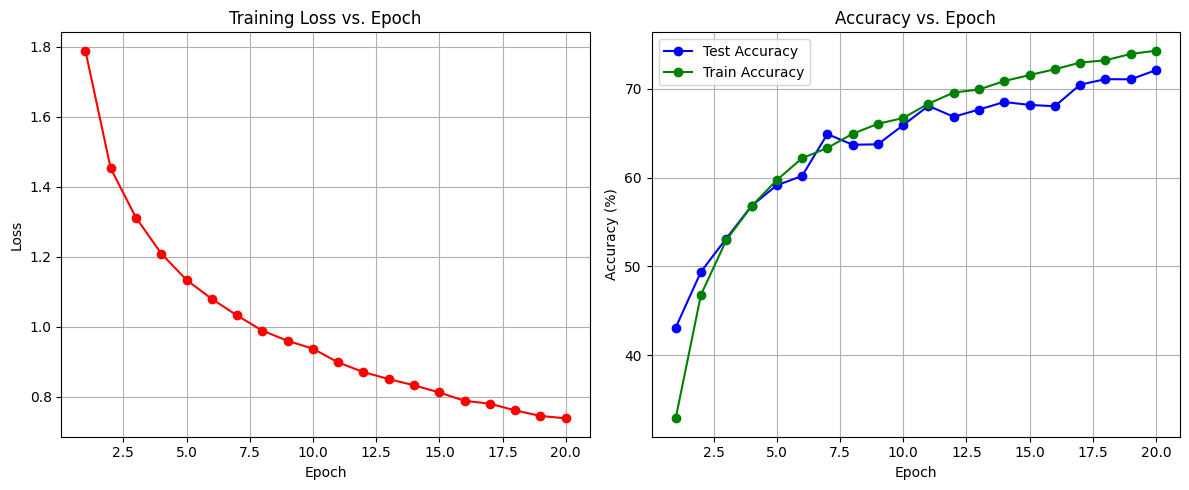

In [ ]:
epochs = range(1, len(epoch_test_accuracy) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Left subplot: Training Loss
axs[0].plot(epochs, epoch_train_loss, marker='o', linestyle='-', color='r')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss vs. Epoch")
axs[0].grid(True)

# Right subplot: Accuracy (both Training and Test)
axs[1].plot(epochs, epoch_test_accuracy, marker='o', linestyle='-', color='b', label='Test Accuracy')
axs[1].plot(epochs, epoch_train_accuracy, marker='o', linestyle='-', color='g', label='Train Accuracy')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Accuracy vs. Epoch")
axs[1].grid(True)
axs[1].legend()  

plt.tight_layout()

plt.show()


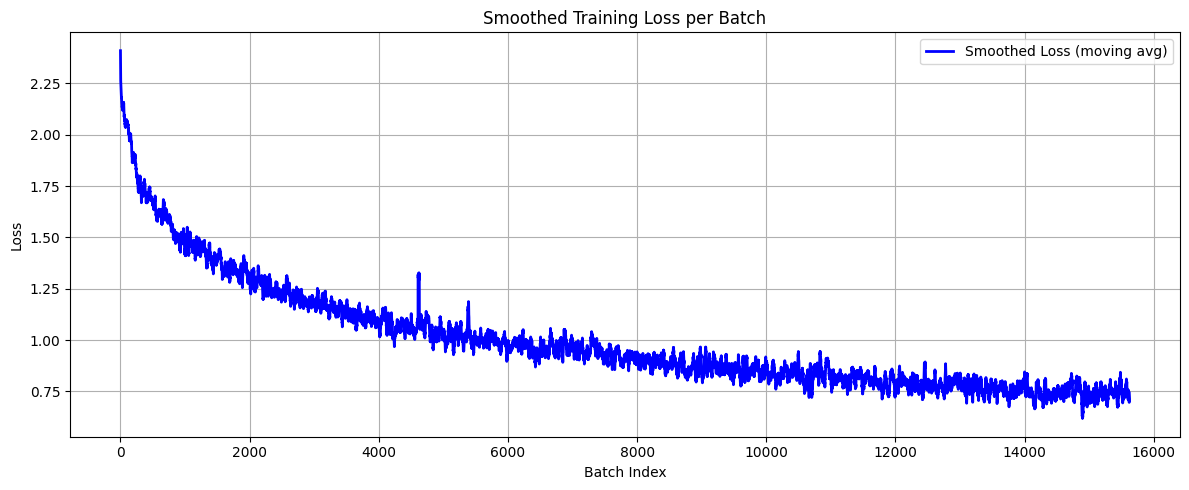

In [126]:
flattened_batch_losses = [loss for epoch_losses in all_batch_losses for loss in epoch_losses]

def moving_average(data, window_size=20):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

smoothed_losses = moving_average(flattened_batch_losses, window_size=20)

plt.figure(figsize=(12, 5))
plt.plot(smoothed_losses, label="Smoothed Loss (moving avg)", color='b', linewidth=2)
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss per Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 4) Tuning

We will use **Optuna**, an open-source hyperparameter optimization framework designed to automate the search process efficiently. Optuna employs sophisticated sampling and pruning algorithms to explore the hyperparameter space intelligently.

## Advantages of Optuna over Grid Search

Compared to a regular Grid Search, Optuna offers several key advantages:

1.  **Efficiency:** Grid Search exhaustively tries every single combination of hyperparameters provided. Optuna uses smarter search strategies (like Tree-structured Parzen Estimator - TPE by default) that learn from past trials and focus on more promising regions of the search space. This often leads to finding good or optimal hyperparameters much faster and with fewer computational resources.
2.  **Smarter Sampling:** Optuna's samplers can handle various parameter types (categorical, integer, float) and distributions (uniform, log-uniform) effectively. It dynamically adjusts its search based on trial results.
3.  **Flexibility:** Optuna makes it easy to define complex search spaces, including conditional hyperparameters (where one hyperparameter only matters if another has a certain value).
4.  **Scalability:** Optuna supports parallel and distributed optimization, allowing you to speed up the search process significantly by running multiple trials concurrently.

## Initial Architecture Modification

Before starting hyperparameter tuning, we will first modify the network architecture. The goal is to enhance its capacity and stability, while also incorporating regularization:

1.  **Modify `IntermediateBlock`:**
    * **Add Batch Normalization:** `nn.BatchNorm2d` layers will be added after each `nn.Conv2d` layer, before the activation function within the `IntermediateBlock`. This helps stabilize training.
    * **Add Second Conv Layer Sequence:** Each parallel branch within the `IntermediateBlock` will now consist of two sequences of `Conv2d -> BatchNorm2d -> Activation`. This increases block capacity to potentially capture finer details.
2.  **Add Dropout in `CIFAR10Net`:** A `nn.Dropout` layer is added just before the final fully connected classification layer (`self.fc`) in the main `CIFAR10Net` module. This acts as a crucial regularizer **to help prevent potential overfitting** by randomly setting a fraction of input units to zero during training.

This modified architecture, incorporating `BatchNorm2d`, the second layer sequence within blocks, and the final `Dropout` layer, will serve as the base model for the hyperparameter optimization process described below.

## Combined Hyperparameter Search with Optuna

Instead of a staged approach, we will perform a single, comprehensive hyperparameter search using Optuna. This allows Optuna to explore the interactions between all tunable parameters simultaneously. We will run the study for a total of **40 trials**.

The following hyperparameters, spanning architecture, optimization, and data settings, will be tuned together in this search:

**Architecture Parameters:**

* `num_blocks`: Number of IntermediateBlocks to stack (`trial.suggest_categorical('num_blocks', [3, 4, 5])`)
* `num_parallel`: Number of parallel paths/branches in each block (`trial.suggest_categorical('num_parallel', [3, 4, 5])`)
* `out_channels`: Number of output channels for convolutional layers (`trial.suggest_categorical('out_channels', [32, 64])`)
* `kernel_size`: Size of the convolution kernels (`trial.suggest_categorical('kernel_size', [3, 5])`)
* `padding`: Padding size for convolutions (`trial.suggest_categorical('padding', [1, 2])`)

**Optimization Parameters:**

* `lr`: Learning Rate (`trial.suggest_float('lr', 1e-5, 1e-2, log=True)`)
* `weight_decay`: L2 Regularization strength (`trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)`)
* `optimizer_name`: Choice of optimizer (`trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'AdamW'])`)

Optuna will explore combinations of these parameters over the 40 trials, aiming to find the configuration that yields the best performance (e.g., highest validation accuracy) on the modified base architecture.

In [ ]:
class IntermediateBlockModded(nn.Module):
    def __init__(self, in_channels, out_channels, num_parallel, kernel_size, padding, activation=nn.ReLU()):
        """
        Args:
            in_channels  : Number of input channels (e.g., 3 for RGB images).
            out_channels : Number of output channels for each conv layer.
            num_parallel : Number of parallel convolutional layers.
        """
        super().__init__()
        self.convs = nn.ModuleList([])
        for _ in range(num_parallel):
            self.convs.append(nn.Sequential(
                # First convolution layer with BN and activation
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels), # added later to extract more details
                activation,
                # Second convolution layer with BN and activation, added later in tuning phase
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                activation,
            ))
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_parallel)
        self.num_parallel = num_parallel

    def forward(self, x):
        conv_outputs = [conv(x) for conv in self.convs] 

        pooled = self.global_pool(x)          
        pooled = pooled.view(pooled.size(0), -1)  
        a = self.fc(pooled)                     
        a = F.softmax(a, dim=1)    

        # Weighted sum of the convolution outputs
        out = 0
        for l in range(self.num_parallel):
            out += conv_outputs[l] * a[:, l].view(-1, 1, 1, 1)

 
        return out 

class CIFAR10NetModded(nn.Module):
    def __init__(self,
                 in_channels,
                 num_classes,
                 out_channels,
                 num_blocks,
                 num_parallel,
                 kernel_size,
                 padding
                 ):

        super().__init__()

        blocks = []
        current_channels = in_channels
        for _ in range(num_blocks):
            blocks.append(IntermediateBlockModded(current_channels, out_channels, num_parallel, kernel_size, padding))
            current_channels = out_channels
        self.blocks = nn.Sequential(*blocks)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.7)
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.blocks(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


In [ ]:
epoch_train_loss_layers = []
epoch_train_accuracy_layers = []
epoch_test_accuracy_layers = []
all_batch_losses_layers = []

print(device)
model = CIFAR10NetModded(
        in_channels=3,
        num_classes=10,
        out_channels=32,
        num_blocks=4,   
        num_parallel=4, 
        kernel_size=3,
        padding=1
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in tqdm(range(num_epochs), desc="Epochs Progress"):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    batch_losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)         # logits shape: (batch_size, 10)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
        batch_losses.append(loss.item())

        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

    # Evaluation on test dataset
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    # print(f"Epoch {epoch+1} completed. Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%\n")

    epoch_train_loss_layers.append(train_loss)
    epoch_train_accuracy_layers.append(train_acc)
    epoch_test_accuracy_layers.append(test_acc)
    all_batch_losses_layers.append(batch_losses)

print("Training complete.")

cuda


Epochs Progress: 100%|██████████| 20/20 [10:47<00:00, 32.35s/it]

Training complete.


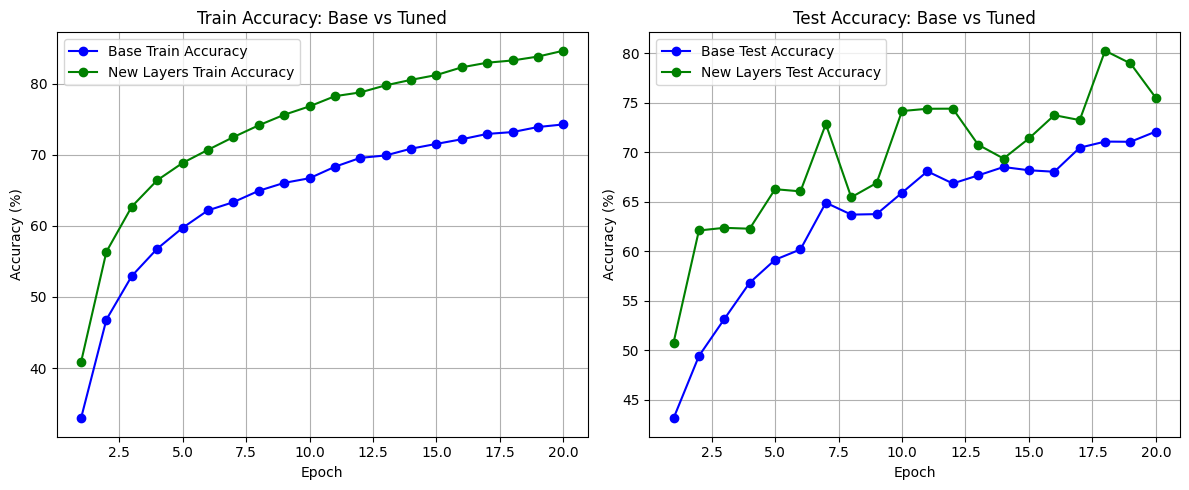

In [ ]:
epochs = range(1, len(epoch_test_accuracy) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axs[0].plot(epochs, epoch_train_accuracy, marker='o', linestyle='-', color='b', label='Base Train Accuracy')
axs[0].plot(epochs, epoch_train_accuracy_layers, marker='o', linestyle='-', color='g', label='New Layers Train Accuracy')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Train Accuracy: Base vs Tuned")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(epochs, epoch_test_accuracy, marker='o', linestyle='-', color='b', label='Base Test Accuracy')
axs[1].plot(epochs, epoch_test_accuracy_layers, marker='o', linestyle='-', color='g', label='New Layers Test Accuracy')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Test Accuracy: Base vs Tuned")
axs[1].grid(True)
axs[1].legend()  

plt.tight_layout()

# Display the plots
plt.show()


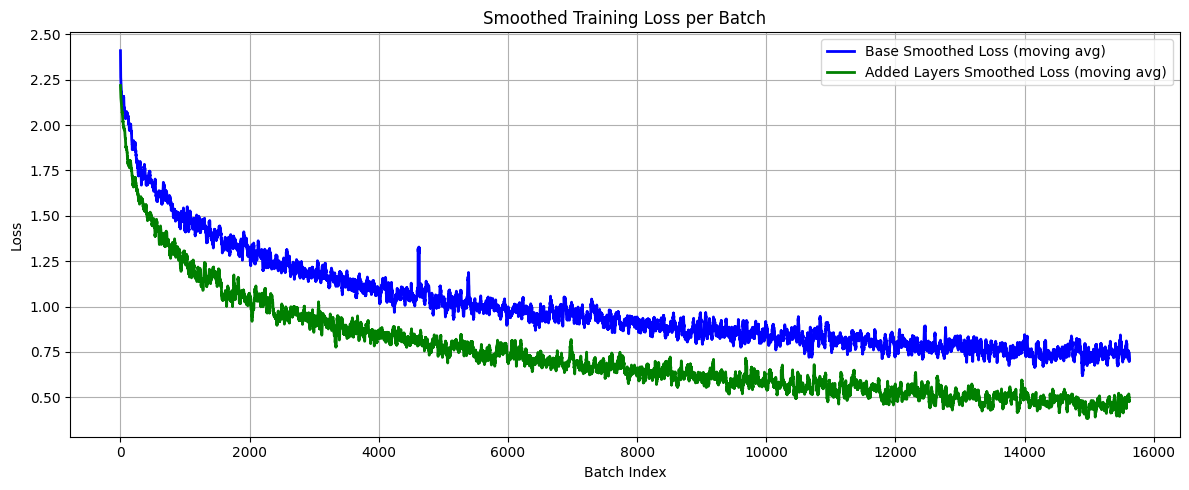

In [130]:
flattened_batch_losses_base = [loss for epoch_losses in all_batch_losses for loss in epoch_losses]
flattened_batch_losses_layers = [loss for epoch_losses in all_batch_losses_layers for loss in epoch_losses]

def moving_average(data, window_size=20):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

smoothed_losses_base = moving_average(flattened_batch_losses_base, window_size=20)
smoothed_losses_layers = moving_average(flattened_batch_losses_layers, window_size=20)

plt.figure(figsize=(12, 5))
plt.plot(smoothed_losses_base, label="Base Smoothed Loss (moving avg)", color='b', linewidth=2)
plt.plot(smoothed_losses_layers, label="Added Layers Smoothed Loss (moving avg)", color='g', linewidth=2)
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss per Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def objective(trial):
    # Suggest hyperparameters from the defined search space
    num_blocks = trial.suggest_categorical('num_blocks', [3, 4, 5, 6, 7])
    num_parallel = trial.suggest_categorical('num_parallel', [3, 4, 5])
    out_channels = trial.suggest_categorical('out_channels', [32, 64])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    padding = trial.suggest_categorical('padding', [1, 2])

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'AdamW'])
    
    # Instantiate the model with current hyperparameters
    model = CIFAR10NetModded(
        in_channels=3,
        num_classes=10,
        out_channels=out_channels,
        num_blocks=num_blocks,
        num_parallel=num_parallel,
        kernel_size=kernel_size,
        padding=padding
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train for 5 epochs to quickly assess the impact of augmentation and batch size.
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
    
    # # Evaluate the model on the test set.
    # model.eval()
    # test_acc = 0.0
    # with torch.no_grad():
    #     for data, target in test_loader:
    #         data, target = data.to(device), target.to(device)
    #         logits = model(data)
    #         test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
    
    # test_acc /= len(test_loader)
    # Evaluate on the test set at the end of the epoch
        model.eval()
        test_acc = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
        test_acc /= len(test_loader)
        
        # Report and possibly prune
        trial.report(test_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return test_acc

# Create an Optuna study to maximize test accuracy.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print the best trial's results.
print("Best trial:")
trial = study.best_trial
print(f"  Test Accuracy: {trial.value:.2f}%")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-07 18:17:58,677] A new study created in memory with name: no-name-2e7888ad-18e0-4685-a330-c4840b357fa2
[I 2025-04-07 18:19:51,856] Trial 0 finished with value: 60.419984076433124 and parameters: {'num_blocks': 3, 'num_parallel': 5, 'out_channels': 32, 'kernel_size': 5, 'padding': 1, 'lr': 0.0002009644496668745, 'weight_decay': 1.526557745920005e-06, 'optimizer': 'AdamW'}. Best is trial 0 with value: 60.419984076433124.
[I 2025-04-07 18:23:51,114] Trial 1 finished with value: 62.291003184713375 and parameters: {'num_blocks': 3, 'num_parallel': 4, 'out_channels': 64, 'kernel_size': 3, 'padding': 2, 'lr': 0.0007974996460689764, 'weight_decay': 0.0009783952332003876, 'optimizer': 'AdamW'}. Best is trial 1 with value: 62.291003184713375.
[I 2025-04-07 18:29:04,088] Trial 2 finished with value: 10.818073248407643 and parameters: {'num_blocks': 5, 'num_parallel': 5, 'out_channels': 64, 'kernel_size': 3, 'padding': 1, 'lr': 1.0939382877577582e-05, 'weight_decay': 1.6874835229219027e

Best trial:
  Test Accuracy: 76.25%
  Best hyperparameters:
    num_blocks: 5
    num_parallel: 3
    out_channels: 64
    kernel_size: 5
    padding: 1
    lr: 0.00012970850431931997
    weight_decay: 0.00036101432184583877
    optimizer: Adam


In [ ]:
from collections import defaultdict
import statistics

def manual_param_importance(study):
    # Create a dictionary to store scores for each parameter and each of its values
    param_groups = defaultdict(lambda: defaultdict(list))
    
    for trial in study.trials:
        if trial.value is None:
            continue
        for param, value in trial.params.items():
            param_groups[param][value].append(trial.value)
    
    # Print out the average score per parameter value
    for param, groups in param_groups.items():
        print(f"Parameter: {param}")
        for value, scores in groups.items():
            mean_score = statistics.mean(scores)
            count = len(scores)
            print(f"   Value: {value} | Mean Accuracy: {mean_score:.2f}% (n={count})")
        print()

manual_param_importance(study)


Parameter: num_blocks
   Value: 3 | Mean Accuracy: 50.84% (n=5)
   Value: 5 | Mean Accuracy: 58.12% (n=22)
   Value: 7 | Mean Accuracy: 50.79% (n=5)
   Value: 6 | Mean Accuracy: 43.56% (n=4)
   Value: 4 | Mean Accuracy: 50.25% (n=4)

Parameter: num_parallel
   Value: 5 | Mean Accuracy: 42.37% (n=7)
   Value: 4 | Mean Accuracy: 48.05% (n=6)
   Value: 3 | Mean Accuracy: 58.41% (n=27)

Parameter: out_channels
   Value: 32 | Mean Accuracy: 49.78% (n=8)
   Value: 64 | Mean Accuracy: 55.12% (n=32)

Parameter: kernel_size
   Value: 5 | Mean Accuracy: 56.24% (n=31)
   Value: 3 | Mean Accuracy: 46.52% (n=9)

Parameter: padding
   Value: 1 | Mean Accuracy: 56.14% (n=32)
   Value: 2 | Mean Accuracy: 45.69% (n=8)

Parameter: lr
   Value: 0.0002009644496668745 | Mean Accuracy: 60.42% (n=1)
   Value: 0.0007974996460689764 | Mean Accuracy: 62.29% (n=1)
   Value: 1.0939382877577582e-05 | Mean Accuracy: 10.82% (n=1)
   Value: 0.0017052643382993262 | Mean Accuracy: 42.44% (n=1)
   Value: 2.1557080739101

In [ ]:
epoch_results_tuning = []

epoch_train_loss_finalV2 = []
epoch_train_accuracy_finalV2 = []
epoch_test_accuracy_finalV2 = []
all_batch_losses_finalV2 = []

model = CIFAR10NetModded(
        in_channels=3,
        num_classes=10,
        out_channels=64,
        num_blocks=5,   
        num_parallel=3,  
        kernel_size=5,
        padding=1
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00012970850431931997, weight_decay=0.00036101432184583877)

num_epochs = 20
for epoch in tqdm(range(num_epochs), desc="Epochs Progress"):
    model.train()

    train_loss = 0.0
    train_acc = 0.0
    batch_losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)         # logits shape: (batch_size, 10)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
        batch_losses.append(loss.item())

        # if batch_idx % 100 == 0:
        #     print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

    # Evaluation on test dataset
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    # print(f"Epoch {epoch+1} completed. Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%\n")

    epoch_train_loss_finalV2.append(train_loss)
    epoch_train_accuracy_finalV2.append(train_acc)
    epoch_test_accuracy_finalV2.append(test_acc)
    all_batch_losses_finalV2.append(batch_losses)

print("Training complete.")


Epochs Progress: 100%|██████████| 20/20 [21:21<00:00, 64.09s/it]

Training complete.


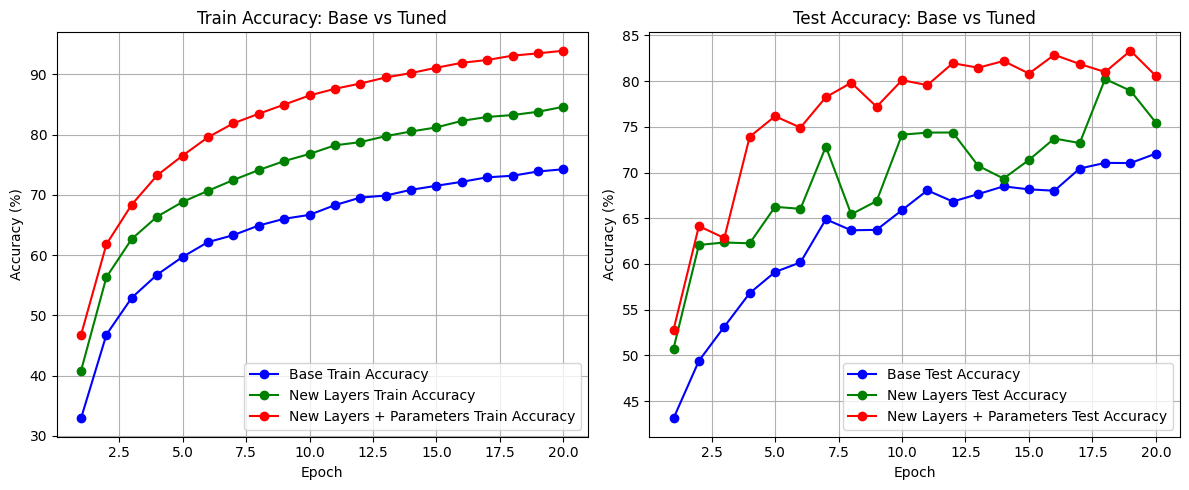

In [ ]:
epochs = range(1, len(epoch_test_accuracy) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Left subplot: Training Loss
axs[0].plot(epochs, epoch_train_accuracy, marker='o', linestyle='-', color='b', label='Base Train Accuracy')
axs[0].plot(epochs, epoch_train_accuracy_layers, marker='o', linestyle='-', color='g', label='New Layers Train Accuracy')
axs[0].plot(epochs, epoch_train_accuracy_finalV2, marker='o', linestyle='-', color='r', label='New Layers + Parameters Train Accuracy')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Train Accuracy: Base vs Tuned")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(epochs, epoch_test_accuracy, marker='o', linestyle='-', color='b', label='Base Test Accuracy')
axs[1].plot(epochs, epoch_test_accuracy_layers, marker='o', linestyle='-', color='g', label='New Layers Test Accuracy')
axs[1].plot(epochs, epoch_test_accuracy_finalV2, marker='o', linestyle='-', color='r', label='New Layers + Parameters Test Accuracy')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Test Accuracy: Base vs Tuned")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

plt.show()


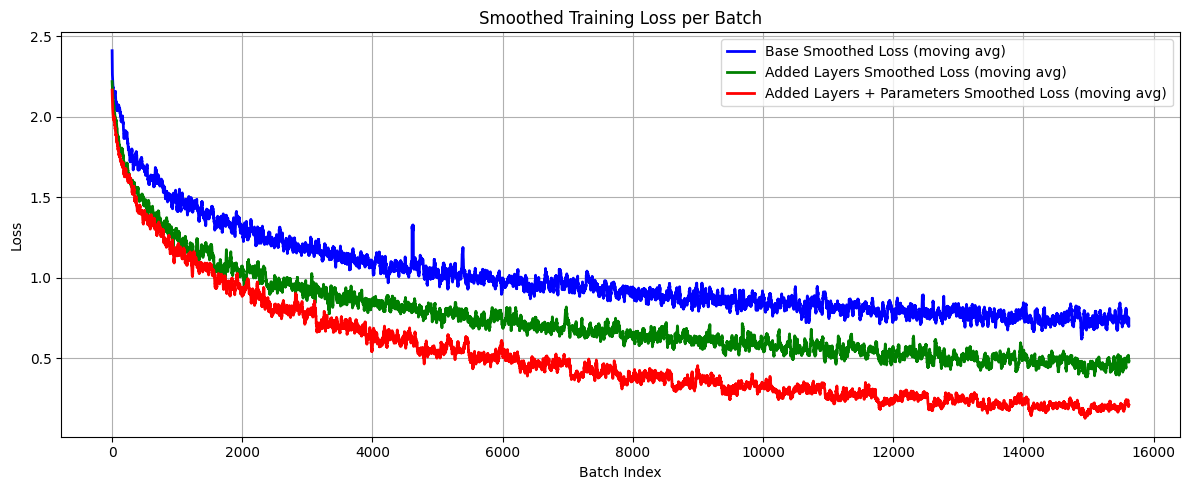

In [134]:
flattened_batch_losses_base = [loss for epoch_losses in all_batch_losses for loss in epoch_losses]
flattened_batch_losses_layers = [loss for epoch_losses in all_batch_losses_layers for loss in epoch_losses]
flattened_batch_losses_final = [loss for epoch_losses in all_batch_losses_finalV2 for loss in epoch_losses]

def moving_average(data, window_size=20):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

smoothed_losses_base = moving_average(flattened_batch_losses_base, window_size=20)
smoothed_losses_layers = moving_average(flattened_batch_losses_layers, window_size=20)
smoothed_losses_final = moving_average(flattened_batch_losses_final, window_size=20)

plt.figure(figsize=(12, 5))
plt.plot(smoothed_losses_base, label="Base Smoothed Loss (moving avg)", color='b', linewidth=2)
plt.plot(smoothed_losses_layers, label="Added Layers Smoothed Loss (moving avg)", color='g', linewidth=2)
plt.plot(smoothed_losses_final, label="Added Layers + Parameters Smoothed Loss (moving avg)", color='r',linewidth=2)
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss per Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
epoch_train_loss_base_model = []
epoch_train_accuracy_base_model = []
epoch_test_accuracy_base_model = []
all_batch_losses_base_model = []

print(device)
model = CIFAR10Net(
        in_channels=3,
        num_classes=10,
        out_channels=32,
        num_blocks=4, 
        num_parallel=4,  
        kernel_size=3,
        padding=1
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
with tqdm(range(num_epochs), desc="Epochs Progress") as pbar:
    for epoch in pbar:    
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        batch_losses = []
    
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)         # logits shape: (batch_size, 10)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
            batch_losses.append(loss.item())
    
            # if batch_idx % 100 == 0:
            #     print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")
    
        # Evaluation on test dataset
        model.eval()
    
        test_acc = 0.0
    
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
    
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        test_acc /= len(test_loader)
    
        # print(f"Epoch {epoch+1} completed. Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%\n")
    
        epoch_train_loss_base_model.append(train_loss)
        epoch_train_accuracy_base_model.append(train_acc)
        epoch_test_accuracy_base_model.append(test_acc)
        all_batch_losses_base_model.append(batch_losses)

        pbar.set_postfix({'Train Acc': f'{train_acc:.2f}', 'Test Acc': f'{test_acc:.2f}'})

print("Training complete.")

cuda


Epochs Progress:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epochs Progress: 100%|██████████| 50/50 [13:19<00:00, 15.98s/it, Train Acc=82.19, Test Acc=72.06]

Training complete.


In [ ]:
epoch_results_tuning = []

epoch_train_loss_final_eval = []
epoch_train_accuracy_final_eval = []
epoch_test_accuracy_final_eval = []
all_batch_losses_final_eval = []

model = CIFAR10NetModded(
        in_channels=3,
        num_classes=10,
        out_channels=64,
        num_blocks=5,   
        num_parallel=3,  
        kernel_size=5,
        padding=1
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00012970850431931997, weight_decay=0.00036101432184583877)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
with tqdm(range(num_epochs), desc="Epochs Progress") as pbar:
    for epoch in pbar:
        model.train()
    
        train_loss = 0.0
        train_acc = 0.0
        batch_losses = []
    
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(data)     
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
            batch_losses.append(loss.item())
    
            # if batch_idx % 100 == 0:
            #     print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")
    
        # Evaluation on test dataset
        model.eval()
    
        test_acc = 0.0
    
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                test_acc += accuracy_fn(y_true=target, y_pred=logits.argmax(dim=1))
    
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        test_acc /= len(test_loader)
    
        # print(f"Epoch {epoch+1} completed. Train Accuracy: {train_acc:.2f}% Test Accuracy: {test_acc:.2f}%\n")
    
        epoch_train_loss_final_eval.append(train_loss)
        epoch_train_accuracy_final_eval.append(train_acc)
        epoch_test_accuracy_final_eval.append(test_acc)
        all_batch_losses_final_eval.append(batch_losses)
    
        pbar.set_postfix({'Train Acc': f'{train_acc:.2f}', 'Test Acc': f'{test_acc :.2f}'})


print("Training complete.")


Epochs Progress: 100%|██████████| 50/50 [29:16<00:00, 35.12s/it, Train Acc=95.66, Test Acc=86.20]

Training complete.


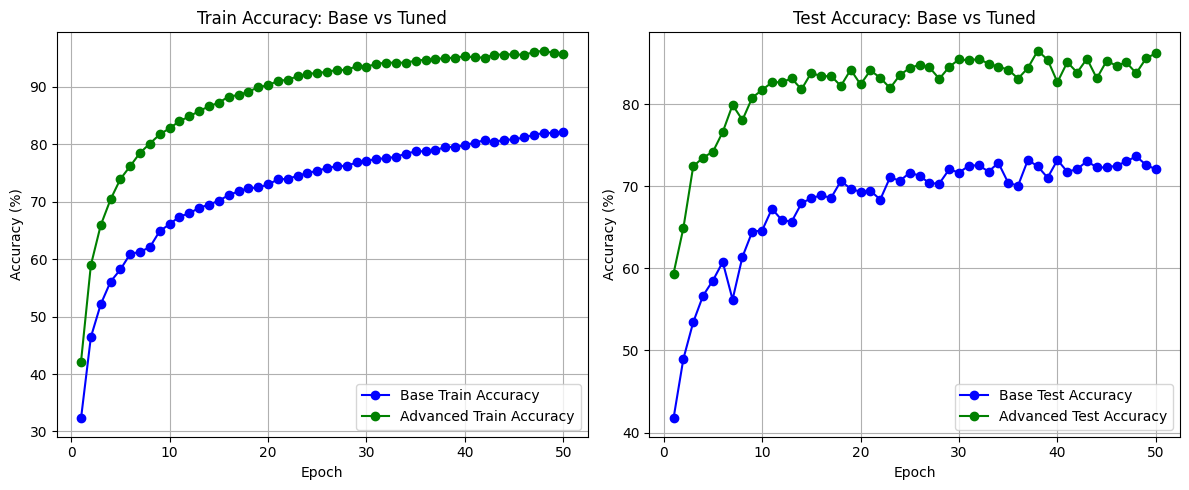

In [ ]:
epochs = range(1, len(epoch_train_accuracy_base_model) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axs[0].plot(epochs, epoch_train_accuracy_base_model, marker='o', linestyle='-', color='b', label='Base Train Accuracy')
axs[0].plot(epochs, epoch_train_accuracy_final_eval, marker='o', linestyle='-', color='g', label='Advanced Train Accuracy')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Train Accuracy: Base vs Tuned")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(epochs, epoch_test_accuracy_base_model, marker='o', linestyle='-', color='b', label='Base Test Accuracy')
axs[1].plot(epochs, epoch_test_accuracy_final_eval, marker='o', linestyle='-', color='g', label='Advanced Test Accuracy')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Test Accuracy: Base vs Tuned")
axs[1].grid(True)
axs[1].legend() 

# Adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()


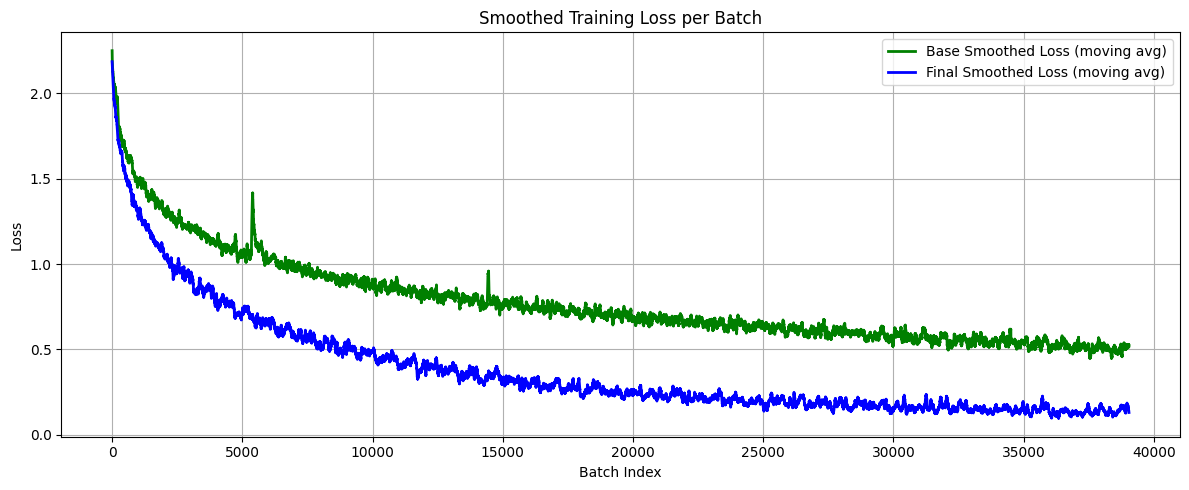

In [20]:
flattened_batch_losses_final_eval = [loss for epoch_losses in all_batch_losses_final_eval for loss in epoch_losses]
flattened_batch_losses_base = [loss for epoch_losses in all_batch_losses_base_model for loss in epoch_losses]

def moving_average(data, window_size=20):
    return [sum(data[i:i+window_size]) / window_size for i in range(len(data) - window_size + 1)]

smoothed_losses_final_eval = moving_average(flattened_batch_losses_final_eval, window_size=50)
smoothed_losses_base_eval = moving_average(flattened_batch_losses_base, window_size=50)

plt.figure(figsize=(12, 5))
plt.plot(smoothed_losses_base_eval, label="Base Smoothed Loss (moving avg)", color='g', linewidth=2)
plt.plot(smoothed_losses_final_eval, label="Final Smoothed Loss (moving avg)", color='b', linewidth=2)
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss per Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
# Get the last value from each list
base_model_test_acc = epoch_test_accuracy_base_model[-1]
base_model_train_acc = epoch_train_accuracy_base_model[-1]
final_eval_test_acc = epoch_test_accuracy_final_eval[-1]
final_eval_train_acc = epoch_train_accuracy_final_eval[-1]
base_model_train_loss = epoch_train_loss_base_model[-1]
final_eval_train_loss = epoch_train_loss_final_eval[-1]

# Create a dictionary with the data
data = {
    "Model-Dataset": ["Base-Train", "Base-Test", "Advanced-Train", "Advanced-Test"],
    # "Loss": [base_model_train_loss, final_eval_train_loss],
    "Accuracy": [base_model_train_acc, base_model_test_acc, final_eval_train_acc, final_eval_test_acc]
}

df = pd.DataFrame(data)

print(df)

    Model-Dataset   Accuracy
0      Base-Train  82.187100
1       Base-Test  72.064092
2  Advanced-Train  95.656170
3   Advanced-Test  86.201035
